## Harmony Py Introduction

This notebook demonstrates several basic examples highlighting how to query and access customized data outputs from NASA Earthdata Harmony.

### Import packages

First we import packages needed to request and visualize our data, as well as the `harmony-py` library itself. Make sure to install `harmony-py` first using PyPI...


In [1]:
import sys; sys.path.append('..')
import datetime as dt
from IPython.display import display, JSON
import rasterio
import rasterio.plot

from harmony import BBox, Client, Collection, Request

### Quick start guide

You can request data using `harmony-py` in just a few easy lines:

```
harmony_client = Client(auth=('EDL_username', 'EDL_password'))
request = Request(
    collection=Collection(id=dataset_short_name),
    spatial=BBox(w, s, e, n),
    temporal={
        'start': dt.datetime(yyyy, mm, dd),
        'stop': dt.datetime(yyyy, mm, dd)
    }
)
job_id = harmony_client.submit(request)
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
```

The guidance below offers more detailed examples highlighting all of the features supported within the Harmony Py library.

### Create Harmony Client object

* Background on what an object is and why we need it.
* Various options to authenticate

In [2]:
harmony_client = Client()

### Create Harmony Request

* Describe all available params offered (more details below)
    * Details on Collection (short name or cmr ID)
    * BBox class
    * Etc...

In [9]:
request = Request(
    collection=Collection(id='C1234088182-EEDTEST'),
#    collection=Collection(id='SENTINEL-1_INTERFEROGRAMS'),
    spatial=BBox(-165, 52, -140, 77),
    temporal={
        'start': dt.datetime(2010, 1, 1),
        'stop': dt.datetime(2020, 12, 30)
    },
    variables=['blue_var'],
    max_results=1,
)

### Check Request validity

### Check Request status

* Let's see how it's going. This will show the percentage complete in the progress field. (We use the JSON helper function to show the results in a nicer-to-look-at format).

* We can check on the progress of a processing job with 'status()'.
* This method blocks while communicating with the server but returns quickly.

In [10]:
JSON(harmony_client.status(job_id))

<IPython.core.display.JSON object>

* 'wait_for_processing()'
* Optionally shows progress bar.
* Blocking.

In [11]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


### View Harmony job response and output URLs

* 'result_json()' calls 'wait_for_processing()' and returns the complete job json once processing is complete.
* Optionally shows progress bar.
* Blocking.

In [13]:
data = harmony_client.result_json(job_id)
data

{'username': 'amy.steiker',
 'status': 'successful',
 'message': 'CMR query identified 32 granules, but the request has been limited to process only the first 1 granules because you requested 1 maxResults.',
 'progress': 100,
 'createdAt': '2021-03-29T22:56:20.319Z',
 'updatedAt': '2021-03-29T22:56:42.876Z',
 'links': [{'title': 'Job Status',
   'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/6a204a29-3837-43fa-aaf2-d8aa848821d5',
   'rel': 'self',
   'type': 'application/json'},
  {'title': 'STAC catalog',
   'href': 'https://harmony.uat.earthdata.nasa.gov/stac/6a204a29-3837-43fa-aaf2-d8aa848821d5/',
   'rel': 'stac-catalog-json',
   'type': 'application/json'},
  {'href': 'https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony/gdal/067fd524-c90d-4707-a525-53ff388665d7/2020_01_01_7f00ff_global_blue_var_subsetted.nc.tif',
   'title': '2020_01_01_7f00ff_global_blue_var_subsetted.nc.tif',
   'type': 'image/tiff',
   'rel': 'data',
   'bbox': [-179.

### Retrieve Harmony output files

* Describe how data are returned as HTTPS URLs, and optionally provided as a STAC catalog with S3 URLs

#### First, HTTPS URL inspection and retrieval:

* 'result_urls()' calls 'wait_for_processing()' and returns the job's data urls once processing is complete.
* Optionally shows progress bar.
* Blocking.


In [14]:
urls = harmony_client.result_urls(job_id)
urls

['https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/harmony/gdal/067fd524-c90d-4707-a525-53ff388665d7/2020_01_01_7f00ff_global_blue_var_subsetted.nc.tif']

* 'download_all()' downloads all data urls and returns immediately with a list of concurrent.futures.
* Optionally shows progress bar for processing only.
* Non-blocking during download but blocking while waitinig for job processing to finish.
* Call 'result()' on future objects to realize them. A call to 'result()' blocks until that particular future finishes downloading. Other futures will download in the background, in parallel, up to the number of workers assigned to the thread pool (thread pool not publicly available).
* Downloading on any unfinished futures can be cancelled early.
* When downloading is complete the futures will return the file path string of the file that was just downloaded. This file path can then be fed into other libraries that may read the data files and perform other operations.

In [16]:
futures = harmony_client.download_all(job_id)
file_names = [f.result() for f in futures]
file_names

['2020_01_01_7f00ff_global_blue_var_subsetted.nc.tif']

* 'download()' will download only the url specified, in case a person would like more control over individual files.
* Returns a future containing the file path string of the file downloaded.
* Blocking upon calling result()

In [17]:
file_name = (harmony_client.download(urls[0], overwrite=True)).result()
file_name

'2020_01_01_7f00ff_global_blue_var_subsetted.nc.tif'

#### Now, STAC inspection and s3 retrieval:

#### test examples

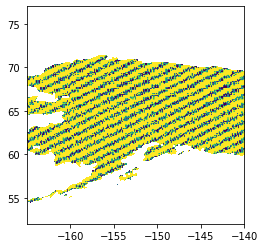

In [8]:
harmony_client = Client()
request = Request(
    collection=Collection(id='C1234088182-EEDTEST'),
#    collection=Collection(id='SENTINEL-1_INTERFEROGRAMS'),
    spatial=BBox(-165, 52, -140, 77),
    temporal={
        'start': dt.datetime(2010, 1, 1),
        'stop': dt.datetime(2020, 12, 30)
    },
    variables=['blue_var'],
    max_results=1,
)
job_id = harmony_client.submit(request)
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
for r in results:
    rasterio.plot.show(rasterio.open(r.result()))